<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Onri's_Custom_LLG_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
export LC_ALL=C.UTF-8
export LANG=C.UTF-8
pip uninstall -y cupy cupy-cuda11x cupy-cuda12x

Found existing installation: cupy-cuda12x 13.3.0
Uninstalling cupy-cuda12x-13.3.0:
  Successfully uninstalled cupy-cuda12x-13.3.0


In [2]:
!pip install cupy-cuda12x

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 MB 18.4 MB/s eta 0:00:00


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [4]:
!nvidia-smi

Thu Mar 20 13:36:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   49C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
##############################
# 0) SETUP & IMPORTS
##############################
# If using Google Colab or a fresh environment:
# !pip install cupy-cuda12x
# (Adjust to match your CUDA version: 11x, 12x, etc.)
# Then restart runtime if asked.

import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

# Increase plot quality and animation embed limit for Colab.
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.embed_limit'] = 100

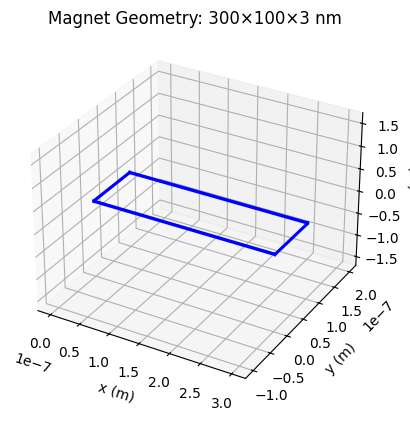

Step 0/201: B=-100.00 mT, Mx=-7.39e+05 A/m
Step 20/201: B=-60.00 mT, Mx=-7.31e+05 A/m
Step 40/201: B=-20.00 mT, Mx=-7.09e+05 A/m
Step 60/201: B=20.00 mT, Mx=6.83e+05 A/m
Step 80/201: B=60.00 mT, Mx=7.31e+05 A/m
Step 100/201: B=100.00 mT, Mx=7.41e+05 A/m
Step 120/201: B=60.00 mT, Mx=7.30e+05 A/m
Step 140/201: B=20.00 mT, Mx=7.10e+05 A/m
Step 160/201: B=-20.00 mT, Mx=-6.80e+05 A/m
Step 180/201: B=-60.00 mT, Mx=-7.30e+05 A/m
Step 200/201: B=-100.00 mT, Mx=-7.41e+05 A/m


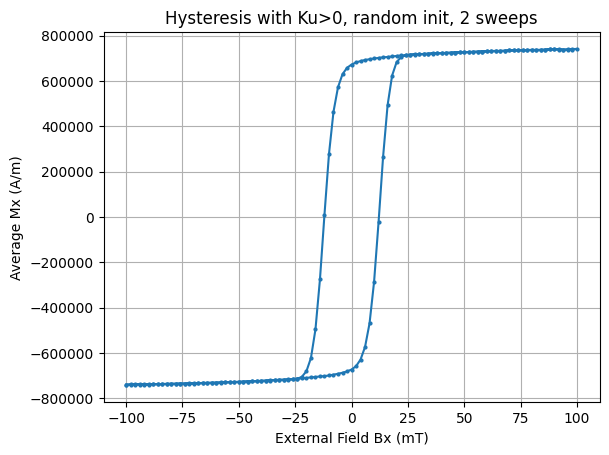

In [4]:
##############################
# 0) SETUP & IMPORTS
##############################
# If using a fresh environment (like in Colab):
# !pip install cupy-cuda12x
# (or cupy-cuda11x, etc., matching your CUDA version)
# Then restart the runtime if asked.

import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed even if we don't call it directly

##############################
# HELPER FUNCTIONS: DRAW 3D BOX & EQUAL AXES
##############################
def draw_box_3d(ax, xlen, ylen, zlen):
    """
    Draw a 3D wireframe box from (0,0,0) to (xlen,ylen,zlen).
    ax: a 3D axes object.
    xlen, ylen, zlen: the dimensions of the box in meters.
    """
    corners = np.array([
        [0,     0,     0    ],
        [xlen,  0,     0    ],
        [xlen,  ylen,  0    ],
        [0,     ylen,  0    ],
        [0,     0,     zlen ],
        [xlen,  0,     zlen ],
        [xlen,  ylen,  zlen ],
        [0,     ylen,  zlen ],
    ])
    edges = [
        (0,1), (1,2), (2,3), (3,0),  # bottom face
        (4,5), (5,6), (6,7), (7,4),  # top face
        (0,4), (1,5), (2,6), (3,7)   # vertical edges
    ]
    for e in edges:
        p1, p2 = corners[e[0]], corners[e[1]]
        ax.plot3D(*zip(p1, p2), color='b')

def set_axes_equal_3d(ax):
    """
    Make the 3D axes of 'ax' have equal scale so that spheres/cubes/etc.
    appear as they do in reality (no distorted aspect ratio).
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = x_limits[1] - x_limits[0]
    y_range = y_limits[1] - y_limits[0]
    z_range = z_limits[1] - z_limits[0]
    max_range = max(x_range, y_range, z_range)

    x_mid = 0.5 * (x_limits[0] + x_limits[1])
    y_mid = 0.5 * (y_limits[0] + y_limits[1])
    z_mid = 0.5 * (z_limits[0] + z_limits[1])

    ax.set_xlim3d([x_mid - 0.5*max_range, x_mid + 0.5*max_range])
    ax.set_ylim3d([y_mid - 0.5*max_range, y_mid + 0.5*max_range])
    ax.set_zlim3d([z_mid - 0.5*max_range, z_mid + 0.5*max_range])

##############################
# 1) SIMULATION PARAMETERS
##############################
# Geometry: 300 nm x 100 nm x 3 nm, cell size = 1 nm
Nx, Ny, Nz = 300, 100, 3
dx, dy, dz = 1e-9, 1e-9, 1e-9

lx, ly, lz = Nx*dx, Ny*dy, Nz*dz  # total size in meters

# Material-like parameters
Ms    = 8.0e5       # A/m
Aex   = 1.3e-11     # J/m
alpha = 0.05        # damping
gamma = 2.211e5     # gyromagnetic ratio (m/As)
mu0   = 4e-7 * np.pi
Ku    = 2.0e4       # small uniaxial anisotropy, J/m^3

# Time integration
dt_relax      = 5e-15
relax_substeps= 30

# Field sweeps:
#   1) -0.1 T -> +0.1 T
#   2) +0.1 T -> -0.1 T
Bmax = 0.1
dB   = 0.002
B_values_up   = np.arange(-Bmax, Bmax + 1e-12, dB)
B_values_down = np.arange(Bmax - dB, -Bmax - 1e-12, -dB)
B_values = np.concatenate([B_values_up, B_values_down])

##############################
# 2) VISUALIZE THE GEOMETRY (3D BOX)
##############################
fig_geom = plt.figure()
ax_geom = fig_geom.add_subplot(projection='3d')
draw_box_3d(ax_geom, lx, ly, lz)
ax_geom.set_xlabel('x (m)')
ax_geom.set_ylabel('y (m)')
ax_geom.set_zlabel('z (m)')
ax_geom.set_title(f"Magnet Geometry: {lx*1e9:.0f}×{ly*1e9:.0f}×{lz*1e9:.0f} nm")
set_axes_equal_3d(ax_geom)  # ensure x,y,z are on same scale
plt.show()

##############################
# 3) INITIAL MAGNETIZATION
##############################
# Start random
m = cp.random.uniform(-1.0, 1.0, size=(3, Nx, Ny, Nz))
norms = cp.sqrt(cp.sum(m**2, axis=0))
norms = cp.where(norms<1e-30, 1.0, norms)
m /= norms

##############################
# 4) DEMAG (FFT) SETUP
##############################
kx = cp.fft.fftfreq(Nx, d=dx)
ky = cp.fft.fftfreq(Ny, d=dy)
kz = cp.fft.fftfreq(Nz, d=dz)

KX, KY, KZ = cp.meshgrid(kx, ky, kz, indexing='ij')
k2 = KX**2 + KY**2 + KZ**2
k2 = cp.where(k2 < 1e-30, 1.0, k2)  # avoid /0

Nxx = KX**2 / k2
Nyy = KY**2 / k2
Nzz = KZ**2 / k2
Nxy = KX*KY / k2
Nxz = KX*KZ / k2
Nyz = KY*KZ / k2

Nxx[0,0,0] = 0
Nyy[0,0,0] = 0
Nzz[0,0,0] = 0
Nxy[0,0,0] = 0
Nxz[0,0,0] = 0
Nyz[0,0,0] = 0

def demag_field(mag):
    """
    H_demag = - Ms ifft{ N(k) * fft(m) }
    """
    m_kx = cp.fft.fftn(mag[0], axes=(0,1,2))
    m_ky = cp.fft.fftn(mag[1], axes=(0,1,2))
    m_kz = cp.fft.fftn(mag[2], axes=(0,1,2))

    Hx_k = -Ms * (Nxx*m_kx + Nxy*m_ky + Nxz*m_kz)
    Hy_k = -Ms * (Nxy*m_kx + Nyy*m_ky + Nyz*m_kz)
    Hz_k = -Ms * (Nxz*m_kx + Nyz*m_ky + Nzz*m_kz)

    Hx = cp.fft.ifftn(Hx_k, axes=(0,1,2)).real
    Hy = cp.fft.ifftn(Hy_k, axes=(0,1,2)).real
    Hz = cp.fft.ifftn(Hz_k, axes=(0,1,2)).real

    return cp.stack((Hx, Hy, Hz), axis=0)

##############################
# 5) EXCHANGE
##############################
def laplacian_3d(vec):
    out = cp.zeros_like(vec)
    for c in range(3):
        f = vec[c]
        fxx = cp.roll(f, 1, axis=0) + cp.roll(f, -1, axis=0) - 2*f
        fyy = cp.roll(f, 1, axis=1) + cp.roll(f, -1, axis=1) - 2*f
        if Nz > 1:
            fzz = cp.roll(f, 1, axis=2) + cp.roll(f, -1, axis=2) - 2*f
        else:
            fzz = 0
        out[c] = (fxx + fyy + fzz) / (dx**2)  # ignoring dx != dy != dz
    return out

def exchange_field(mag):
    coef = 2.0 * Aex / (mu0 * Ms**2)
    return coef * laplacian_3d(mag)

##############################
# 6) UNAXIAL ANISOTROPY
##############################
def anisotropy_field(mag):
    mx = mag[0]
    dot_mx = mx
    coeff = 2.0 * Ku / (mu0 * Ms)
    Hx = coeff * dot_mx
    Hy = cp.zeros_like(mx)
    Hz = cp.zeros_like(mx)
    return cp.stack((Hx, Hy, Hz), axis=0)

##############################
# 7) LLG
##############################
def llg_rhs(mag, Hx):
    # external field in x
    H_ext = cp.zeros_like(mag)
    H_ext[0] = Hx

    H_dem = demag_field(mag)
    H_ex  = exchange_field(mag)
    H_ani = anisotropy_field(mag)

    H_eff = H_ext + H_dem + H_ex + H_ani

    cross_mH = cp.cross(mag.transpose(1,2,3,0),
                        H_eff.transpose(1,2,3,0), axis=3)
    cross_mH = cross_mH.transpose(3,0,1,2)
    dm_dt_precess = - gamma * cross_mH

    cross_m_dm = cp.cross(mag.transpose(1,2,3,0),
                          dm_dt_precess.transpose(1,2,3,0), axis=3)
    cross_m_dm = cross_m_dm.transpose(3,0,1,2)
    dm_dt_damp = alpha * gamma * cross_m_dm

    return dm_dt_precess + dm_dt_damp

def llg_heun_step(mag, Hx, dt):
    k1 = llg_rhs(mag, Hx)
    m_tilde = mag + dt*k1

    # renormalize predictor
    lens_tilde = cp.sqrt(cp.sum(m_tilde**2, axis=0))
    lens_tilde = cp.where(lens_tilde<1e-30, 1.0, lens_tilde)
    m_tilde /= lens_tilde

    k2 = llg_rhs(m_tilde, Hx)
    m_new = mag + 0.5*dt*(k1 + k2)

    # renormalize final
    lens_new = cp.sqrt(cp.sum(m_new**2, axis=0))
    lens_new = cp.where(lens_new<1e-30, 1.0, lens_new)
    m_new /= lens_new

    return m_new

##############################
# 8) MAIN LOOP: 2 SWEEPS
##############################
m_local = m.copy()
mx_vals = []
field_vals = []

for i, Bx in enumerate(B_values):
    # Convert T to A/m
    Hx_am = Bx / mu0

    # "Relax" for 'relax_substeps' steps
    for _ in range(relax_substeps):
        m_local = llg_heun_step(m_local, Hx_am, dt_relax)

    # measure average Mx in A/m
    mx_avg = (cp.mean(m_local[0]) * Ms).get()

    mx_vals.append(mx_avg)
    field_vals.append(Bx)

    if i % 20 == 0:
        print(f"Step {i}/{len(B_values)}: B={Bx*1e3:.2f} mT, Mx={mx_avg:.2e} A/m")

##############################
# 9) PLOT HYSTERESIS: Mx vs Bx
##############################
field_vals = np.array(field_vals)
mx_vals = np.array(mx_vals)

plt.figure()
plt.plot(field_vals*1e3, mx_vals, '-o', ms=2)
plt.xlabel('External Field Bx (mT)')
plt.ylabel('Average Mx (A/m)')
plt.title('Hysteresis with Ku>0, random init, 2 sweeps')
plt.grid(True)
plt.show()
